In [16]:
import numpy as np
from matplotlib import pyplot as plt
import cv2 as cv
import os
from sklearn.cluster import KMeans
import pandas as pd
import random
import torch
import clip
import tqdm
from PIL import Image
from sklearn.neighbors import NearestNeighbors

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

100%|███████████████████████████████████████| 338M/338M [01:53<00:00, 3.11MiB/s]


In [4]:
pascal_dir = "pascal"

In [7]:
def load_image_for_clip(image_filename):
    return preprocess(Image.open(image_filename)).unsqueeze(0).to(device)

In [10]:
def encode_with_clip(model, image_filename):
    image = load_image_for_clip(image_filename)
    image_features = model.encode_image(image)
    image_features = image_features.cpu().detach().numpy().squeeze().astype(np.float64)
    return image_features

In [13]:
def fill_df(model, dir):
    data = pd.DataFrame(columns=["image_path", "vector"])

    files = os.listdir(dir)
    for i in tqdm.tqdm(range(len(files))):
        image_filename = files[i]
        image_filename = os.path.join(dir, image_filename)
        features = encode_with_clip(model, image_filename)

        if features is not None:
            data.loc[len(data.index)] = [image_filename, features]

    return data

In [14]:
data = fill_df(model, pascal_dir)
data

100%|██████████| 17125/17125 [04:12<00:00, 67.76it/s]


,image_path,vector
0,pascal\2007_000027.jpg,"[-0.701171875, 0.390869140625, -0.058898925781..."
1,pascal\2007_000032.jpg,"[-0.1346435546875, 0.01137542724609375, -0.022..."
2,pascal\2007_000033.jpg,"[0.116455078125, 0.2401123046875, -0.239135742..."
3,pascal\2007_000039.jpg,"[-0.049041748046875, 0.77978515625, 0.40283203..."
4,pascal\2007_000042.jpg,"[0.196533203125, 0.2086181640625, -0.348388671..."
...,...,...
17120,pascal\2012_004326.jpg,"[-0.491943359375, 0.20361328125, -0.2275390625..."
17121,pascal\2012_004328.jpg,"[-0.016876220703125, -0.1650390625, 0.03952026..."
17122,pascal\2012_004329.jpg,"[-0.0025806427001953125, 0.20849609375, 0.1306..."
17123,pascal\2012_004330.jpg,"[-0.259521484375, 0.0770263671875, -0.63330078..."


In [15]:
data.to_csv("image_database_clip.csv")

## Ищем похожие

In [17]:
X = np.vstack(data["vector"].values)
X

array([[-0.70117188,  0.39086914, -0.05889893, ...,  0.68896484,
         0.00895691,  0.50341797],
       [-0.13464355,  0.01137543, -0.02252197, ...,  0.48266602,
        -0.07611084,  0.19506836],
       [ 0.11645508,  0.2401123 , -0.23913574, ...,  0.51074219,
         0.19628906, -0.16442871],
       ...,
       [-0.00258064,  0.20849609,  0.13061523, ...,  0.27319336,
        -0.13757324,  0.9296875 ],
       [-0.25952148,  0.07702637, -0.63330078, ...,  0.78076172,
        -0.31201172, -0.10522461],
       [ 0.07202148, -0.10418701, -0.12432861, ...,  0.32641602,
         0.50634766,  0.18017578]])

In [18]:
neighbours_model = NearestNeighbors(metric='cosine', algorithm='brute')
neighbours_model.fit(X)

NearestNeighbors(algorithm='brute', metric='cosine')

In [19]:
def show_image(img, cmap=None):
    plt.figure(figsize=(15, 9))
    img_to_show = img
    if img.ndim == 3:
        img_to_show = img[:,:,::-1]
    elif cmap is None:
        cmap = "gray"

    if cmap:
        plt.imshow(img_to_show, cmap=cmap)
    else:
        plt.imshow(img_to_show)

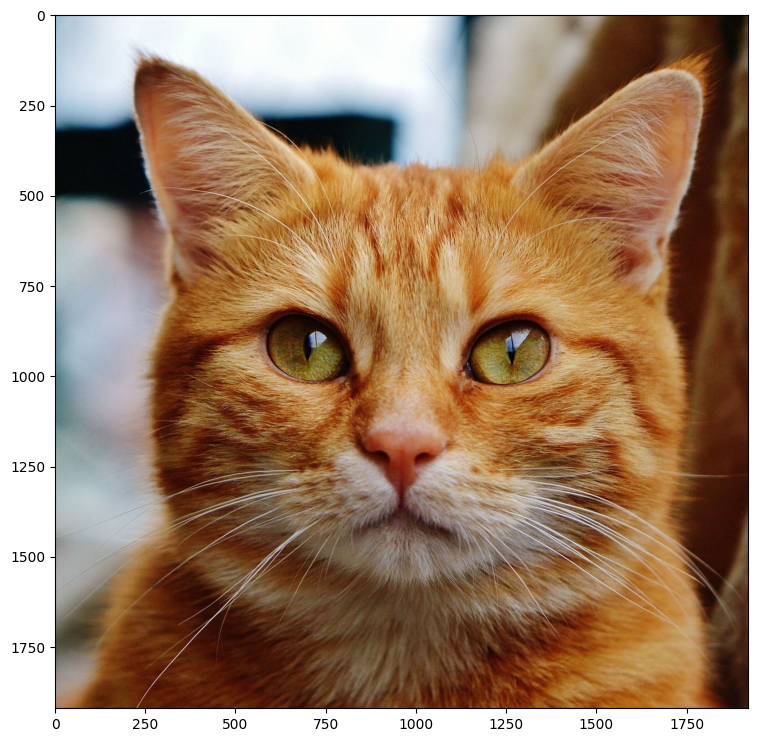

In [70]:
input_filename = "tests/cat.jpg"
input_image = cv.imread(input_filename)
show_image(input_image)

In [71]:
input_vector = encode_with_clip(model, input_filename)
input_vector

array([ 1.57470703e-01, -2.15209961e-01,  1.42700195e-01, -4.93408203e-01,
       -2.38647461e-01, -5.10253906e-01,  3.58642578e-01,  4.60449219e-01,
        1.36352539e-01, -7.51953125e-02,  4.02832031e-01, -2.86132812e-01,
        3.50585938e-01, -2.70751953e-01,  3.75244141e-01,  1.81030273e-01,
        8.62792969e-01,  5.67321777e-02,  3.66943359e-01,  5.50231934e-02,
        2.43286133e-01, -2.52685547e-02,  4.21630859e-01, -3.33984375e-01,
       -4.33593750e-01,  3.89160156e-01,  4.17724609e-01,  1.98852539e-01,
        7.88574219e-02, -2.52929688e-01, -1.19934082e-01,  1.58813477e-01,
        4.70275879e-02,  2.57812500e-01,  2.89306641e-01,  2.50000000e-01,
        5.27343750e-02, -2.04589844e-01,  1.88751221e-02,  1.40917969e+00,
       -4.80957031e-01, -3.31787109e-01, -3.64013672e-01, -3.10058594e-01,
       -8.24584961e-02, -1.68334961e-01, -4.77905273e-02,  2.66601562e-01,
        3.89404297e-02, -1.60400391e-01, -1.02172852e-01,  1.60644531e-01,
       -1.71813965e-02,  

In [72]:
distances, indices = neighbours_model.kneighbors([input_vector], n_neighbors=10)
indices[0]

array([10581, 10720,  2772,  8974,  1022, 12695,  6145,  6307,  1172,
          35], dtype=int64)

In [73]:
pics_pathes = data.loc[indices[0]]["image_path"]
pics_pathes

10581    pascal\2010_005535.jpg
10720    pascal\2010_005806.jpg
2772     pascal\2008_004074.jpg
8974     pascal\2010_002333.jpg
1022     pascal\2008_000536.jpg
12695    pascal\2011_002685.jpg
6145     pascal\2009_002040.jpg
6307     pascal\2009_002352.jpg
1172     pascal\2008_000839.jpg
35       pascal\2007_000549.jpg
Name: image_path, dtype: object

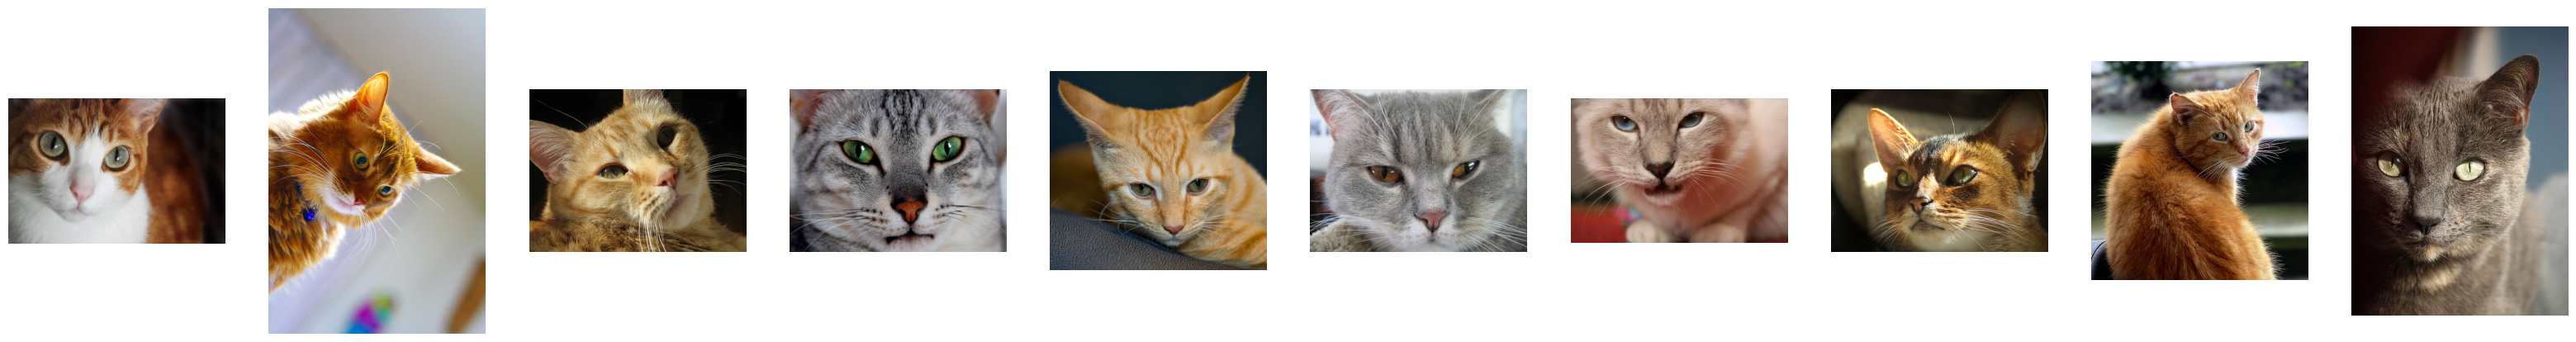

In [74]:
fig, ax = plt.subplots(1, 10, figsize=(40, 30))
for i, image_path in enumerate(pics_pathes):
    img = cv.imread(image_path)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    ax[i].imshow(img)
    ax[i].axis('off')